In [1]:
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import Tensor
import torch
from torch.optim import Adam, SGD, Adamax
from sklearn.preprocessing import MinMaxScaler

# Models
First let's define our models, and the baseline model (ModelReLU). The latter will be used to compare our model in the defined task.

In [2]:
from localized_look.model import LoLoLayer


class ModelLoLo(nn.Module):
    def __init__(self, activation="invsquare"):
        super().__init__()
        self.layer = nn.Sequential(
            LoLoLayer(n_kernels=120, n_channels=2, fusion="channels", activation=activation),
            nn.LeakyReLU(.05),
            nn.Linear(120, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layer(x)

class ModelReLU(nn.Module):
    
    def __init__(self):
        super().__init__()
        n = 64
        self.layer = nn.Sequential(
            nn.Linear(2, n//2),
            nn.LeakyReLU(.05),
            nn.Linear(n//2, n),
            nn.LeakyReLU(.05),
            nn.Linear(n, n//2),
            nn.LeakyReLU(.05),
            nn.Linear(n//2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layer(x)

In [3]:
model_lolo = ModelLoLo()
model_relu = ModelReLU()

In [4]:
model_lolo

ModelLoLo(
  (layer): Sequential(
    (0): LoLoLayer(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=120, bias=True)
          (1): LoLoInvSquare()
        )
        (1): Sequential(
          (0): Linear(in_features=1, out_features=120, bias=True)
          (1): LoLoInvSquare()
        )
      )
    )
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=120, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [5]:
for param in list(model_lolo.layer.children())[0].parameters():
    print(param)

Parameter containing:
tensor([[[ 0.6626,  0.1068],
         [ 0.6345,  0.4751],
         [-0.9580,  0.8026],
         [ 0.8656,  0.2875],
         [ 0.5833,  0.6709],
         [ 0.5466,  0.1104],
         [-0.6363, -0.7702],
         [ 0.7604,  0.0846],
         [ 0.2246, -0.8349],
         [ 0.6673,  0.6027],
         [-0.4947,  0.7735],
         [-0.2516,  0.3741],
         [-0.0125, -0.9889],
         [ 0.1917, -0.5897],
         [ 0.7637,  0.8493],
         [-0.8476,  0.6763],
         [ 0.3049, -0.1431],
         [-0.0041, -0.2310],
         [ 0.4261,  0.3336],
         [-0.3843, -0.0094],
         [-0.9039, -0.9373],
         [-0.4743, -0.1621],
         [ 0.4218, -0.6092],
         [-0.3358, -0.8781],
         [-0.3781, -0.4853],
         [-0.3847, -0.3962],
         [ 0.1613,  0.6101],
         [ 0.6417, -0.6909],
         [ 0.9883,  0.1318],
         [-0.1699, -0.2301],
         [ 0.0894, -0.7690],
         [-0.4007, -0.3311],
         [ 0.8575, -0.1380],
         [-0.6302, -0

In [6]:
model_relu

ModelReLU(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

# Benchmark
Our dataset will be a "checkerboard" like, i.e., with sparse locals where the label is one. The net figure is a visualization of this. There is 2 features (X and Y).

In [28]:
from torch.utils.data import DataLoader, Dataset
from localized_look.utils import create_labels_checker


class dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
#         self.w = w
        assert len(x) == len(y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]#, self.w[i]


scaler = MinMaxScaler(feature_range=(-5, 5))
    
x = np.random.rand(50000, 2)*180-90
y = create_labels_checker(x, 7, size=1, stride=5, start=-50, size_factor=1.6, stride_factor=1.25)
# y = ((x > -15) & (x < - 5)) | ((x > 5) & (x < 15)) 

w = (y * .9 + .05).flatten()

idx = np.random.choice(np.arange(len(x)), size=3000, p=w/w.sum() , replace=False)

x = x[idx]
y = y[idx]

print(y.mean())

x = scaler.fit_transform(x)

x_true, y_true = x.copy(), y.copy()

x, y = torch.Tensor(x), torch.Tensor(y)

trainloader = torch.utils.data.DataLoader(
    dataset(x, y),
    batch_size=64,
    shuffle=True,
    num_workers=0
)
_ = model_lolo(x), model_relu(x)

0.45866666666666667


Just checking that all models are comparable in the number of parameters (the ReLU model has 6 more parameters).

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("LoLo model n parameters:", count_parameters(model_lolo))
print("ReLU model n parameters:", count_parameters(model_relu))

LoLo model n parameters: 961
ReLU model n parameters: 4321


This is our training data. We can see that the label (Z axis) is 1 in specific points of the dataset.

Text(0.5, 0, 'Label')

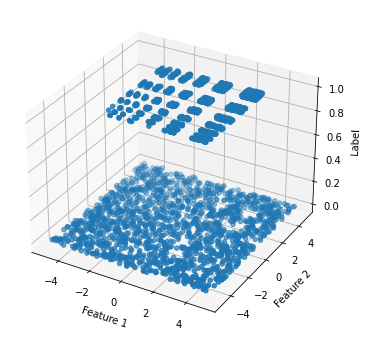

In [30]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:, 0], x[:, 1], y)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')

# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111)

# ax.scatter(x[:, 0], y)

In [31]:
from torch.optim.optimizer import Optimizer, required
import math

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

c:\users\paulo\anaconda3\envs\lolo\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
c:\users\paulo\anaconda3\envs\lolo\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


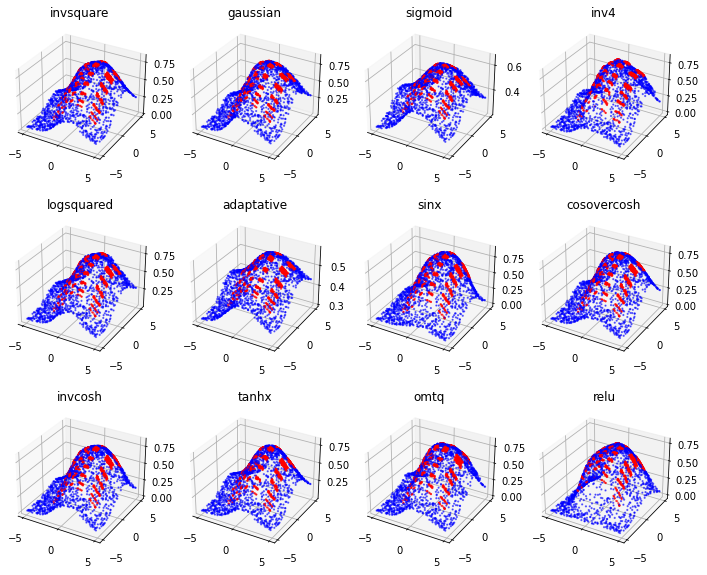

Epoch 0 :
invsquare loss:0.623, Mean batch time: 5.028ms
gaussian loss:0.628, Mean batch time: 3.896ms
sigmoid loss:0.658, Mean batch time: 4.680ms
inv4 loss:0.575, Mean batch time: 5.051ms
logsquared loss:0.604, Mean batch time: 4.444ms
adaptative loss:0.691, Mean batch time: 5.030ms
sinx loss:0.571, Mean batch time: 4.190ms
cosovercosh loss:0.607, Mean batch time: 4.891ms
invcosh loss:0.594, Mean batch time: 4.633ms
tanhx loss:0.605, Mean batch time: 3.802ms
omtq loss:0.580, Mean batch time: 3.718ms
relu loss:0.584, Mean batch time: 2.757ms


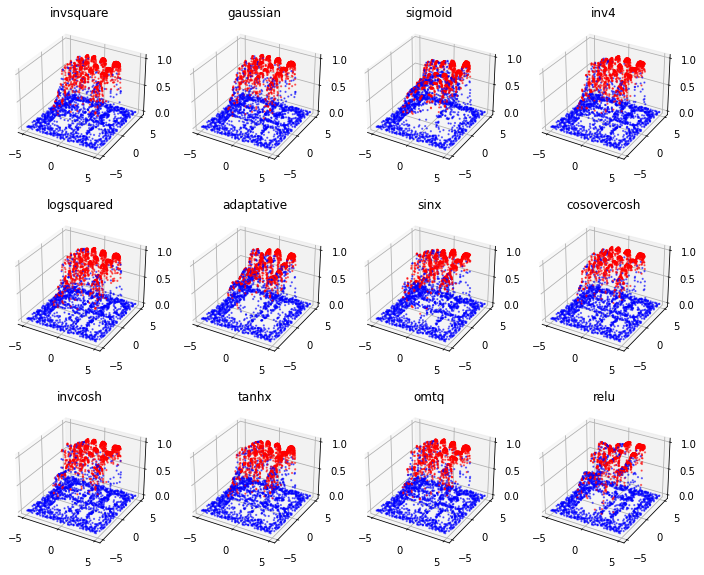

Epoch 100 :
invsquare loss:0.160, Mean batch time: 4.201ms
gaussian loss:0.157, Mean batch time: 4.112ms
sigmoid loss:0.329, Mean batch time: 4.327ms
inv4 loss:0.165, Mean batch time: 4.661ms
logsquared loss:0.178, Mean batch time: 4.270ms
adaptative loss:0.273, Mean batch time: 5.494ms
sinx loss:0.201, Mean batch time: 3.858ms
cosovercosh loss:0.139, Mean batch time: 4.344ms
invcosh loss:0.162, Mean batch time: 4.748ms
tanhx loss:0.194, Mean batch time: 3.902ms
omtq loss:0.168, Mean batch time: 3.958ms
relu loss:0.252, Mean batch time: 2.609ms


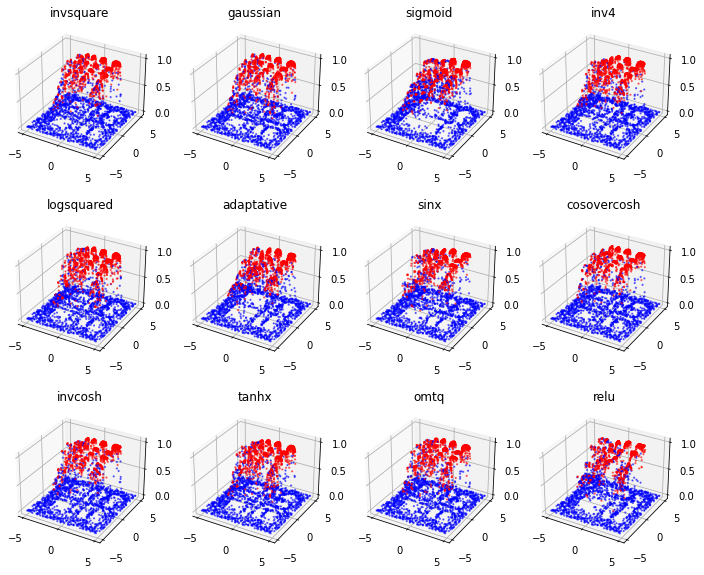

Epoch 200 :
invsquare loss:0.142, Mean batch time: 4.126ms
gaussian loss:0.143, Mean batch time: 4.020ms
sigmoid loss:0.267, Mean batch time: 4.254ms
inv4 loss:0.146, Mean batch time: 4.569ms
logsquared loss:0.160, Mean batch time: 4.207ms
adaptative loss:0.211, Mean batch time: 5.401ms
sinx loss:0.170, Mean batch time: 3.817ms
cosovercosh loss:0.114, Mean batch time: 4.248ms
invcosh loss:0.139, Mean batch time: 4.667ms
tanhx loss:0.163, Mean batch time: 3.823ms
omtq loss:0.150, Mean batch time: 3.887ms
relu loss:0.206, Mean batch time: 2.347ms


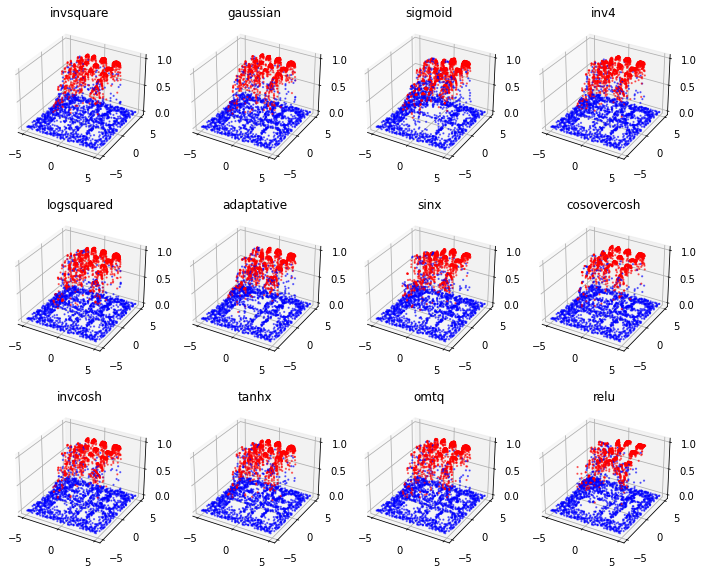

Epoch 300 :
invsquare loss:0.133, Mean batch time: 4.099ms
gaussian loss:0.135, Mean batch time: 4.013ms
sigmoid loss:0.243, Mean batch time: 4.257ms
inv4 loss:0.137, Mean batch time: 4.546ms
logsquared loss:0.150, Mean batch time: 4.202ms
adaptative loss:0.191, Mean batch time: 5.391ms
sinx loss:0.160, Mean batch time: 3.819ms
cosovercosh loss:0.105, Mean batch time: 4.244ms
invcosh loss:0.129, Mean batch time: 4.650ms
tanhx loss:0.152, Mean batch time: 3.805ms
omtq loss:0.141, Mean batch time: 3.883ms
relu loss:0.178, Mean batch time: 2.241ms


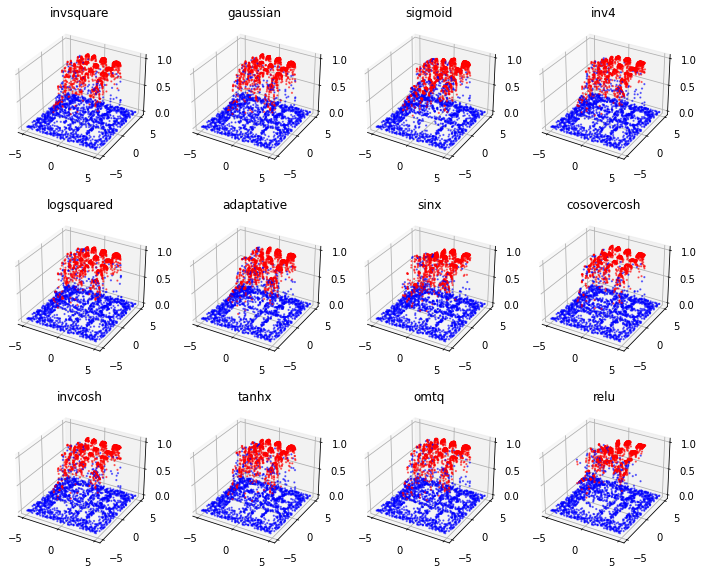

Epoch 400 :
invsquare loss:0.129, Mean batch time: 4.098ms
gaussian loss:0.130, Mean batch time: 4.018ms
sigmoid loss:0.220, Mean batch time: 4.255ms
inv4 loss:0.133, Mean batch time: 4.541ms
logsquared loss:0.146, Mean batch time: 4.206ms
adaptative loss:0.181, Mean batch time: 5.387ms
sinx loss:0.155, Mean batch time: 3.827ms
cosovercosh loss:0.102, Mean batch time: 4.245ms
invcosh loss:0.124, Mean batch time: 4.647ms
tanhx loss:0.147, Mean batch time: 3.803ms
omtq loss:0.137, Mean batch time: 3.881ms
relu loss:0.167, Mean batch time: 2.391ms


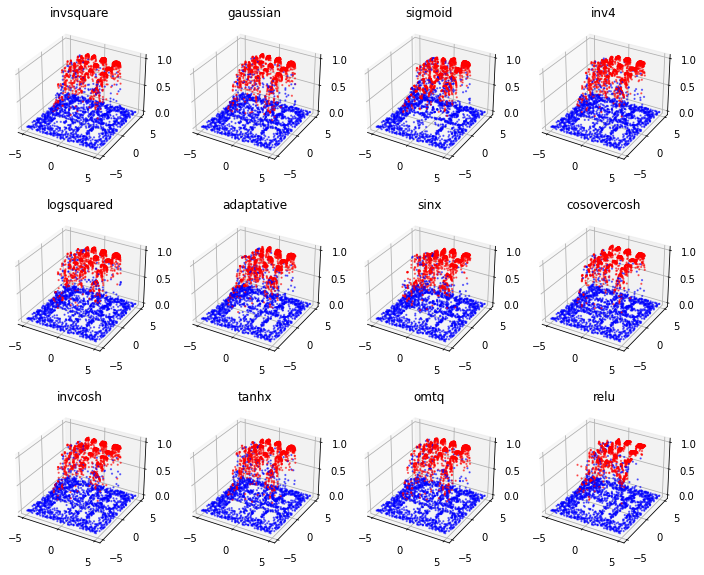

Epoch 500 :
invsquare loss:0.126, Mean batch time: 4.102ms
gaussian loss:0.127, Mean batch time: 4.017ms
sigmoid loss:0.209, Mean batch time: 4.257ms
inv4 loss:0.127, Mean batch time: 4.548ms
logsquared loss:0.142, Mean batch time: 4.210ms
adaptative loss:0.167, Mean batch time: 5.394ms
sinx loss:0.149, Mean batch time: 3.846ms
cosovercosh loss:0.098, Mean batch time: 4.267ms
invcosh loss:0.120, Mean batch time: 4.660ms
tanhx loss:0.143, Mean batch time: 3.814ms
omtq loss:0.133, Mean batch time: 3.887ms
relu loss:0.152, Mean batch time: 2.225ms


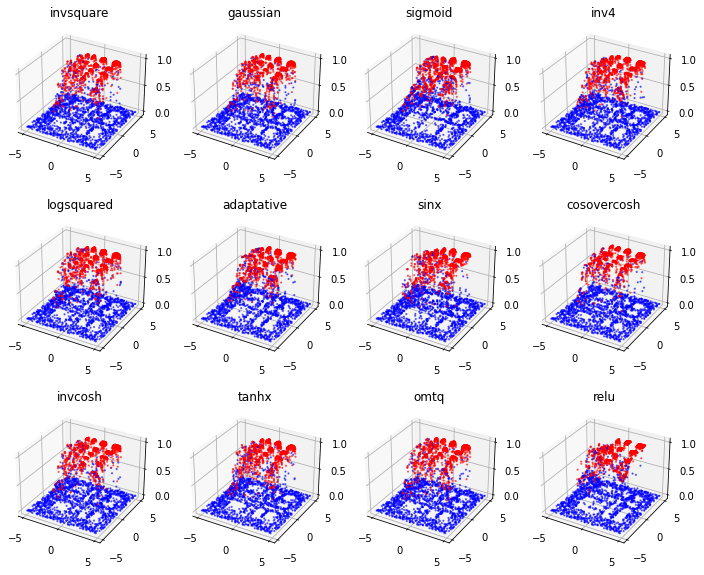

Epoch 600 :
invsquare loss:0.123, Mean batch time: 4.108ms
gaussian loss:0.123, Mean batch time: 4.034ms
sigmoid loss:0.202, Mean batch time: 4.272ms
inv4 loss:0.125, Mean batch time: 4.555ms
logsquared loss:0.140, Mean batch time: 4.221ms
adaptative loss:0.160, Mean batch time: 5.405ms
sinx loss:0.145, Mean batch time: 3.856ms
cosovercosh loss:0.096, Mean batch time: 4.279ms
invcosh loss:0.117, Mean batch time: 4.668ms
tanhx loss:0.140, Mean batch time: 3.823ms
omtq loss:0.130, Mean batch time: 3.898ms
relu loss:0.148, Mean batch time: 3.317ms


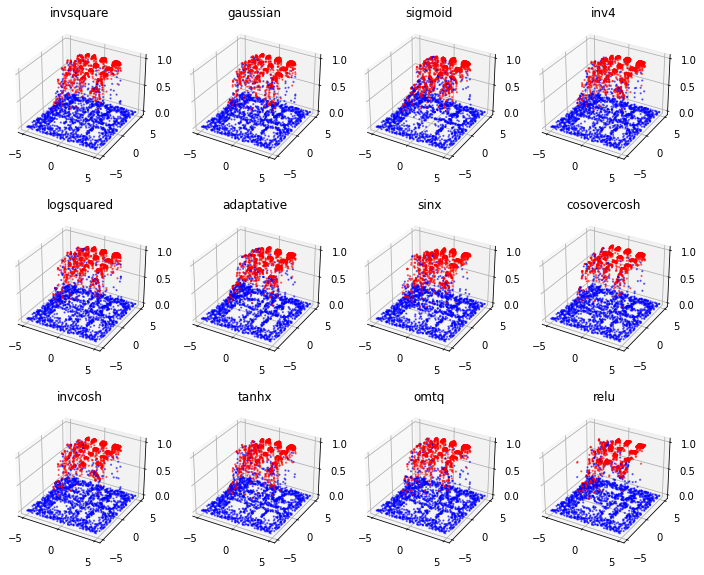

Epoch 700 :
invsquare loss:0.121, Mean batch time: 4.097ms
gaussian loss:0.121, Mean batch time: 4.026ms
sigmoid loss:0.198, Mean batch time: 4.264ms
inv4 loss:0.122, Mean batch time: 4.545ms
logsquared loss:0.137, Mean batch time: 4.210ms
adaptative loss:0.156, Mean batch time: 5.398ms
sinx loss:0.142, Mean batch time: 3.851ms
cosovercosh loss:0.094, Mean batch time: 4.275ms
invcosh loss:0.115, Mean batch time: 4.657ms
tanhx loss:0.138, Mean batch time: 3.812ms
omtq loss:0.128, Mean batch time: 3.888ms
relu loss:0.141, Mean batch time: 2.378ms


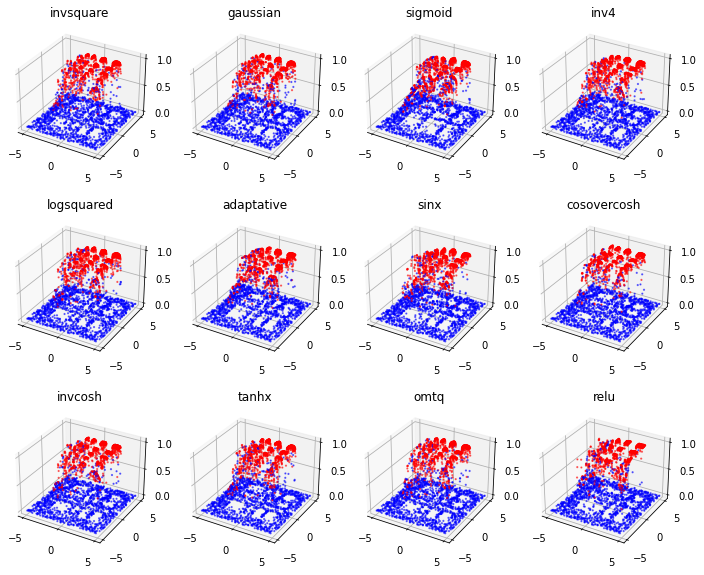

Epoch 800 :
invsquare loss:0.119, Mean batch time: 4.091ms
gaussian loss:0.119, Mean batch time: 4.018ms
sigmoid loss:0.194, Mean batch time: 4.257ms
inv4 loss:0.120, Mean batch time: 4.537ms
logsquared loss:0.136, Mean batch time: 4.200ms
adaptative loss:0.153, Mean batch time: 5.396ms
sinx loss:0.140, Mean batch time: 3.854ms
cosovercosh loss:0.093, Mean batch time: 4.280ms
invcosh loss:0.113, Mean batch time: 4.652ms
tanhx loss:0.137, Mean batch time: 3.804ms
omtq loss:0.127, Mean batch time: 3.885ms
relu loss:0.136, Mean batch time: 2.284ms


In [32]:
from localized_look.utils import weight_init
import localized_look.activation as act
import time

activations = act.ACTIVATION_DICT

models = {act:ModelLoLo(activation=act) for act in activations}
models.update(
    {
        "relu": ModelReLU()
    }
)

for model in models.values():
    model.apply(weight_init)
    model.train()

# optimizers = {model_key:SGD(models[model_key].parameters(), lr=1e-3) for model_key in models}
# optimizers = {model_key:Adamax(models[model_key].parameters(), lr=1e-2) for model_key in models}
# optimizers = {model_key:RAdam(models[model_key].parameters()) for model_key in models}

loss_fn = nn.BCELoss()

times = {model_key:[] for model_key in models}
for epoch in range(0, 801):
    optimizers = {model_key:Adam(models[model_key].parameters(), lr=1e-2/(1 + epoch/40)) for model_key in models}
    losses = {model_key:[] for model_key in models}
    for x, y in trainloader:
        for optim in optimizers.values():
            optim.zero_grad()
        # ModelLoLo
        for model_key in models:
            start_time = time.time()
            pred = models[model_key].forward(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizers[model_key].step()
            losses[model_key] += [loss.item()]
            end_time = time.time()
            delta = end_time - start_time
            times[model_key] += [delta]
    # Calculate mean time using the last 5 epochs
    times[model_key] =  times[model_key][-len(trainloader)*5:]
    if epoch % 100 == 0:
        
        x, y = x_true, y_true

        fig = plt.figure(figsize=(12, 10))
        if x.shape[1] == 2:
            axes = [fig.add_subplot(3, 4, i + 1, projection='3d') for i in range(len(models))]
            for i, model_key in enumerate(models):
                pred = models[model_key].forward(torch.Tensor(x_true)).detach().numpy()
                axes[i].scatter(x[:, 0], x[:, 1], pred, c=y, alpha=.5, s=1.5, cmap="bwr")
                axes[i].set_title(model_key)
            plt.show()
        if x.shape[1] == 1:
            axes = [fig.add_subplot(3, 4, i+1) for i in range(len(models))]
            for i, model_key in enumerate(models):
                interm = list(list(models[model_key].layer.children())[0].layers.children())[0]
                pred = models[model_key].forward(torch.Tensor(x_true)).detach().numpy()
                axes[i].scatter(x[:, 0], pred, c=y, alpha=.5, s=1.5, cmap="bwr")
                a, b = x_true.flatten(), interm.forward(torch.Tensor(x_true)).detach().numpy()
                for j in range(b.shape[1]):
                    axes[i].scatter(a, b[:, j], alpha=.2, s=1., cmap="bwr")
                axes[i].set_title(model_key)
            plt.show()
        
        print("Epoch", epoch, ":")
        for model_key in models:
            print(
                "{} loss:{:.3f}, Mean batch time: {:.3f}ms".format(
                    model_key,
                    np.mean(losses[model_key]),
                    np.mean(times[model_key])*1000,
                )
            )

In [33]:
from sklearn.metrics import balanced_accuracy_score
print("Balanced accuracy scores")
for i, model_key in enumerate(models):
    pred = models[model_key].forward(torch.Tensor(x_true)).detach().numpy().flatten()
    score1 = balanced_accuracy_score(y_true, pred > .25)
    score2 = balanced_accuracy_score(y_true, pred > .5)
    score3 = balanced_accuracy_score(y_true, pred > .75)
    print("{}: {:.3f} | {:.3f} | {:.3f}".format(model_key, score1, score2, score3))


Balanced accuracy scores
invsquare: 0.949 | 0.954 | 0.930
gaussian: 0.946 | 0.955 | 0.929
sigmoid: 0.908 | 0.923 | 0.874
inv4: 0.946 | 0.953 | 0.932
logsquared: 0.941 | 0.948 | 0.919
adaptative: 0.929 | 0.942 | 0.906
sinx: 0.935 | 0.948 | 0.914
cosovercosh: 0.960 | 0.967 | 0.947
invcosh: 0.950 | 0.954 | 0.936
tanhx: 0.936 | 0.948 | 0.912
omtq: 0.944 | 0.951 | 0.926
relu: 0.934 | 0.946 | 0.917
